# Sélection des variables et corrélations
## Import des données
L'étude se fera à partir de janvier 1990.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

""" Import de la variable cible : conso """

conso = pd.read_csv('Ressources/Consommation des ménages trimestrielle.csv',sep=';')
conso = conso.set_index('Période').replace({',':'.'},regex=True).astype('float64')

""" Import des variables explicatives : goods, services, retail_trade """

goods = pd.read_csv('Ressources/Goods index.csv',sep=';').drop(range(6))
goods = goods.rename({'Titre :':'Date'},axis='columns').set_index('Date').replace({',':'.'},regex=True).astype('float64')

services = pd.read_csv('Ressources/Services index.csv',sep=';').drop(range(4))
services = services.rename({'Titre :':'Date'},axis='columns').set_index('Date').replace({',':'.'},regex=True).astype('float64')

retail_trade = pd.read_csv('Ressources/Retail trade index.csv',sep=';').drop(range(4)).reset_index().drop('index',axis=1)
retail_trade = retail_trade.rename({'Titre :':'Date'},axis='columns').set_index('Date').replace({',':'.'},regex=True).astype('float64')

""" Limitation des dates d'étude """

services_90 = services.loc['Déc 2019':'Jan 1990'].reset_index()
goods_90 = goods.loc[:'01/01/1990'].reset_index()
goods_90['Date'] = retail_trade.reset_index()['Date'] 

services_2000 = services.loc['Déc 2019':'Jan 2000'].reset_index()
goods_2000 = goods.loc[:'01/01/2000'].reset_index()
goods_2000['Date'] = retail_trade.reset_index()['Date']

""" Constitution de la variable cible yty-var """

var = []
for i in range(4,len(conso),1):
    var.append(float(conso['TOTAL '].iloc[i]/conso['TOTAL '].iloc[i-4] - 1))
yty_var = pd.DataFrame({'Variations de la consommation':var, 'Date':list(conso.index)[4:]})
yty_var = yty_var.set_index('Date')

yty_var_2000 = yty_var.loc['2000T1':] # On ne prédit qu'à partir de 2000

""" Constitution d'une dataframe X explicative, et constitution d'une yty-var-indice """

X = retail_trade.merge(services_90,on='Date').merge(goods_90,on='Date').set_index('Date')
X_trimestriel = pd.DataFrame([X.iloc[3*k:3*(k+1)].mean() for k in range(int(len(X)/3))],columns=X.columns,index=conso.index[::-1]).iloc[::-1]

X_2000 = retail_trade.merge(services_2000,on='Date').merge(goods_2000,on='Date').set_index('Date')
X_2000_trimestriel = pd.DataFrame([X_2000.iloc[3*k:3*(k+1)].mean() for k in range(int(len(X_2000)/3))],columns=X_2000.columns,index=yty_var_2000.index[::-1])
X_2000_trimestriel = X_2000_trimestriel.fillna(method='ffill')

var_indice = []
for i in range(4,len(X_trimestriel),1):
    var_indice.append(X_trimestriel.iloc[i]/X_trimestriel.iloc[i-4] - 1)

var_indice = np.array(var_indice)
var_indice[var_indice == np.inf] = 0
var_indice[var_indice == -np.inf] = 0

yty_var_indice = pd.DataFrame(var_indice,index=yty_var.index,columns = X.columns)

yty_var_indice_2000 = yty_var_indice.loc['2000T1':]


""" Normalisation des matrices """

Y_norm = StandardScaler().fit_transform(yty_var)
X_norm = StandardScaler().fit_transform(X)

Y_norm_2000 = pd.DataFrame(StandardScaler().fit_transform(yty_var_2000),index=yty_var_2000.index,columns=yty_var_2000.columns).astype('float64')
X_norm_2000 = pd.DataFrame(StandardScaler().fit_transform(X_2000_trimestriel[::-1]),index=X_2000_trimestriel[::-1].index,columns=X_2000_trimestriel[::-1].columns).astype('float64')
X_norm_2000 = X_norm_2000.fillna(X_norm_2000.mean()) # On veut d'abord tester une régression sur les niveaux

X_var_norm_2000 = pd.DataFrame(StandardScaler().fit_transform(yty_var_indice_2000),index=yty_var_indice_2000.index,columns=yty_var_indice_2000.columns).astype('float64')

X_var_norm_2000 = X_norm_2000.fillna(X_var_norm_2000.mean())

X_norm_2000 = X_norm_2000.fillna(X_norm_2000.mean())

Il faut encore supprimer les colonnes comportant trop de NaN. Il n'y a plus de NaN jusqu'à la ligne 117.

On peut aussi considérer plusieurs modèles : ceux qui essaient de se baser sur un maximum d'indices mais des données que récentes, et ceux qui ne se basent que sur la portion des indices les plus anciens.

## Régression Lasso
### En niveaux

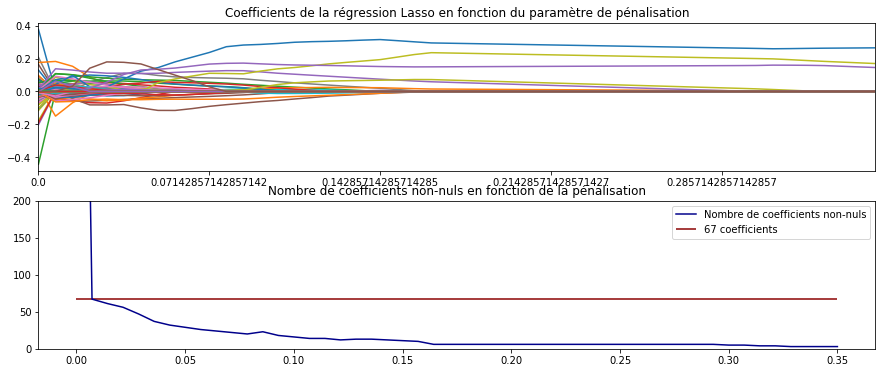

In [84]:
coefs = pd.DataFrame(index=X_norm_2000.columns)
alphas = np.linspace(0,0.35)
nbr_coef_non_nuls = []

for alpha in alphas:
    clf = Lasso(alpha=alpha)
    clf.fit(X_norm_2000, Y_norm_2000)
    coefs[str(alpha)] = clf.coef_
    nbr_coef_non_nuls.append(np.count_nonzero(clf.coef_))

fig, (ax,ax_nbr_coefs) = plt.subplots(2,1,figsize=(20,15))

coefs.T.plot(ax=ax,legend=False,title="Coefficients de la régression Lasso en fonction du paramètre de pénalisation",figsize=(15,6))

ax_nbr_coefs.set_title("Nombre de coefficients non-nuls en fonction de la pénalisation")
ax_nbr_coefs.set_ylim(0,200)
ax_nbr_coefs.hlines(67,0,0.35,label='67 coefficients',color='darkred')
ax_nbr_coefs.plot(alphas,nbr_coef_non_nuls,label='Nombre de coefficients non-nuls',color='darkblue')
plt.legend()

plt.show()

On peut ainsi penser à 4 modèles différents:
* Un très complexe avec alpha = 0.01
* Un complexe avec alpha = 0.06
* Un simple avec alpha = 0.175
* Un très simple avec alpha = 0.35

Pour étudier la corrélation des variables, on peut se pencher sur les modèles complexes (alpha petit).

### Quelles sont les variables retenues ?

In [59]:
coefs2 = pd.DataFrame(index=X_norm_2000.columns)
alphas = [0.01020408,0.06,0.175,0.35]

for alpha in alphas:
    clf = Lasso(alpha=alpha)
    clf.fit(X_norm_2000, Y_norm_2000)
    coefs2[str(alpha)] = clf.coef_

variables_modele_tres_complexe = list(coefs2.loc[coefs2['0.01020408']!=0].index)
variables_modele_complexe = list(coefs2.loc[coefs2['0.06']!=0].index)
variables_modele_simple = list(coefs2.loc[coefs2['0.175']!=0].index)
variables_modele_tres_simple = list(coefs2.loc[coefs2['0.35']!=0].index)

### En variations yty

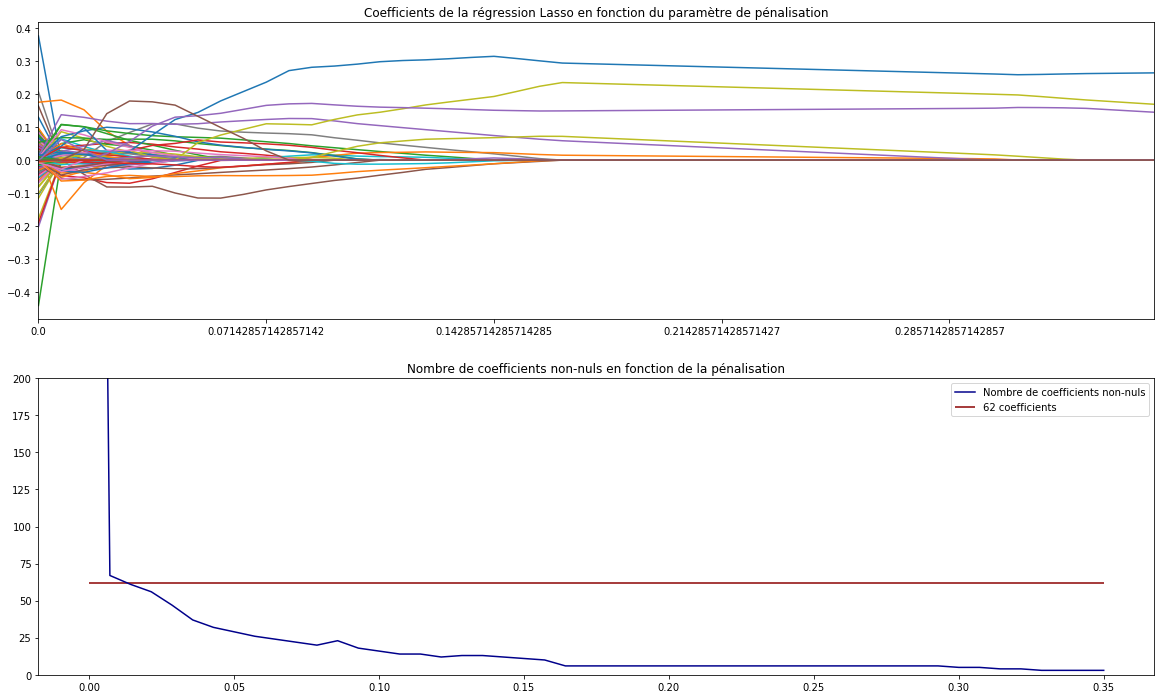

In [69]:
coefs_var = pd.DataFrame(index=X_var_norm_2000.columns)
alphas_var = np.linspace(0,0.35)
nbr_coef_non_nuls_var = []

for alpha in alphas_var:
    clf_var = Lasso(alpha=alpha)
    clf_var.fit(X_var_norm_2000, Y_norm_2000)
    coefs_var[str(alpha)] = clf_var.coef_
    nbr_coef_non_nuls_var.append(np.count_nonzero(clf_var.coef_))

fig2, (ax2,ax3) = plt.subplots(2,1)

coefs_var.T.plot(ax=ax2,legend=False,title="Coefficients de la régression Lasso en fonction du paramètre de pénalisation",figsize=(20,15))

ax3.set_title("Nombre de coefficients non-nuls en fonction de la pénalisation")
ax3.set_ylim(0,200)
ax3.hlines(62,0,0.35,label='62 coefficients',color='darkred')
ax3.plot(alphas_var,nbr_coef_non_nuls_var,label='Nombre de coefficients non-nuls',color='darkblue')
plt.legend()

plt.show()

In [161]:
coefs_var2 = pd.DataFrame(index=X_norm_2000.columns)
alphas = [0.00714286,0.06,0.175,0.35]

for alpha in alphas:
    clf_var = Lasso(alpha=alpha)
    clf_var.fit(X_var_norm_2000, Y_norm_2000)
    coefs_var2[str(alpha)] = clf_var.coef_

variables_modele_tres_complexe_var = list(coefs_var2.loc[coefs_var2['0.00714286']!=0].index)
variables_modele_complexe_var = list(coefs_var2.loc[coefs_var2['0.06']!=0].index)
variables_modele_simple_var = list(coefs_var2.loc[coefs_var2['0.175']!=0].index)
variables_modele_tres_simple_var = list(coefs_var2.loc[coefs_var2['0.35']!=0].index)

Ces dernières variables permettent d'étudier plus succintement les corrélations avec yty-var. Les variables retenues sont à peu près les mêmes, que l'on considère les séries en niveaux ou différentiées. 

## Meme chose avec des datasets propres
À partir de Mars 2010

In [224]:
X_cleared = X.iloc[:117,:]

X_cleared_trimestriel = [X_cleared.iloc[3*k:3*(k+1)].mean() for k in range(int(len(X_cleared)/3))]
X_cleared_trimestriel = pd.DataFrame(X_cleared_trimestriel,columns=X_cleared.columns,index=conso.iloc[81:,:].index[::-1])
X_cleared_trimestriel_norm = (X_cleared_trimestriel - X_cleared_trimestriel.mean())/X_cleared_trimestriel.std()
X_cleared_trimestriel_norm = X_cleared_trimestriel_norm.fillna(0)

yty_var_cleared_lvl = yty_var.iloc[77:]

var_indice_cleared, var_indice_cleared_index = [], []
for i in range(len(X_cleared_trimestriel)-4):
    var_indice_cleared.append(X_cleared_trimestriel.iloc[i]/X_cleared_trimestriel.iloc[i+4] - 1)
    var_indice_cleared_index.append(X_cleared_trimestriel.index[i])

yty_var_indice_cleared = pd.DataFrame(var_indice_cleared, index=var_indice_cleared_index, columns=X_cleared_trimestriel.columns)
yty_var_indice_cleared = (yty_var_indice_cleared - yty_var_indice_cleared.mean())/yty_var_indice_cleared.std()

yty_var_indice_cleared = yty_var_indice_cleared.replace([np.inf, -np.inf], np.nan).fillna(0)

yty_var_cleared_var = yty_var.iloc[81:]

### En niveaux

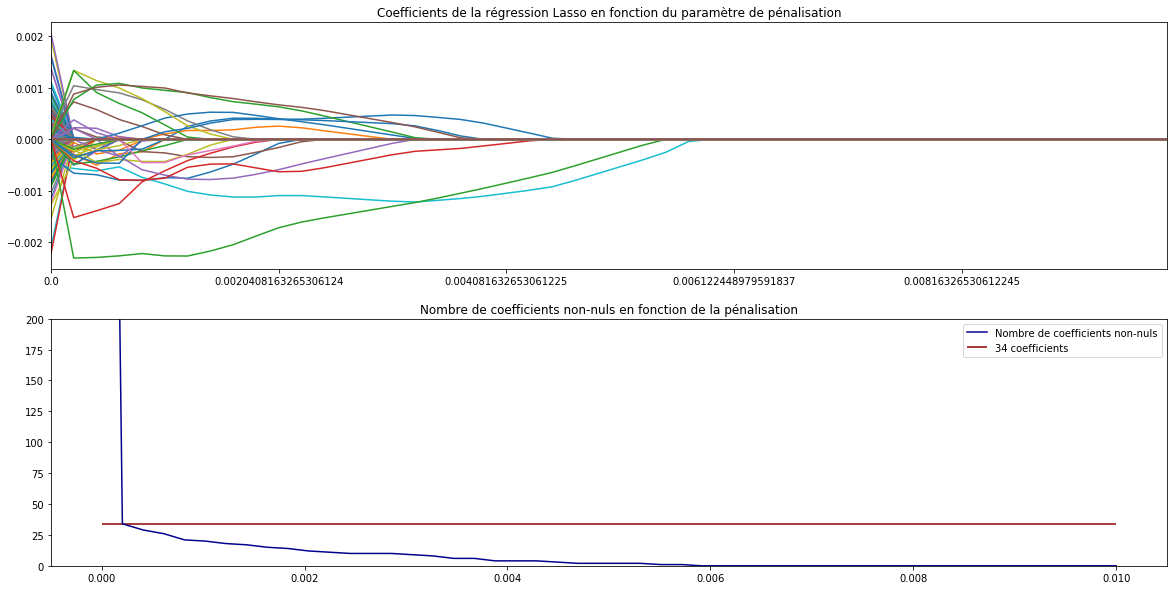

In [194]:
coefs_cleared_lvl = pd.DataFrame(index=X_cleared_trimestriel_norm.columns)
alphas_cleared_lvl = np.linspace(0,0.01)
nbr_coef_non_nuls_cleared_lvl = []

for alpha in alphas_cleared_lvl:
    clf = Lasso(alpha=alpha)
    clf.fit(X_cleared_trimestriel_norm, yty_var_cleared_lvl)
    coefs_cleared_lvl[str(alpha)] = clf.coef_
    nbr_coef_non_nuls_cleared_lvl.append(np.count_nonzero(clf.coef_))

fig_cleared_lvl, (ax_cleared_lvl,ax_nbr_coefs_cleared_lvl) = plt.subplots(2,1,figsize=(15,8))

coefs_cleared_lvl.T.plot(ax=ax_cleared_lvl,legend=False,title="Coefficients de la régression Lasso en fonction du paramètre de pénalisation")

ax_nbr_coefs_cleared_lvl.set_title("Nombre de coefficients non-nuls en fonction de la pénalisation")
ax_nbr_coefs_cleared_lvl.set_ylim(0,200)
ax_nbr_coefs_cleared_lvl.hlines(34,0,0.01,label='34 coefficients',color='darkred')
ax_nbr_coefs_cleared_lvl.plot(alphas_cleared_lvl,nbr_coef_non_nuls_cleared_lvl,label='Nombre de coefficients non-nuls',color='darkblue')
plt.legend()

plt.show()

In [248]:
coefs_lvl2 = pd.DataFrame(index=X_cleared_trimestriel_norm.columns)
alphas = [0.00010204,0.00112245,0.0022449,0.00326531]

for alpha in alphas:
    clf_lvl = Lasso(alpha=alpha)
    clf_lvl.fit(X_cleared_trimestriel_norm, yty_var_cleared_lvl)
    coefs_lvl2[str(alpha)] = clf_lvl.coef_

variables_modele_tres_complexe_cleared_lvl = list(coefs_lvl2.loc[coefs_lvl2['0.00010204']!=0].index)
variables_modele_complexe_cleared_lvl = list(coefs_lvl2.loc[coefs_lvl2['0.00112245']!=0].index)
variables_modele_simple_cleared_lvl = list(coefs_lvl2.loc[coefs_lvl2['0.0022449']!=0].index)
variables_modele_tres_simple_cleared_lvl = list(coefs_lvl2.loc[coefs_lvl2['0.00326531']!=0].index)

### En variations

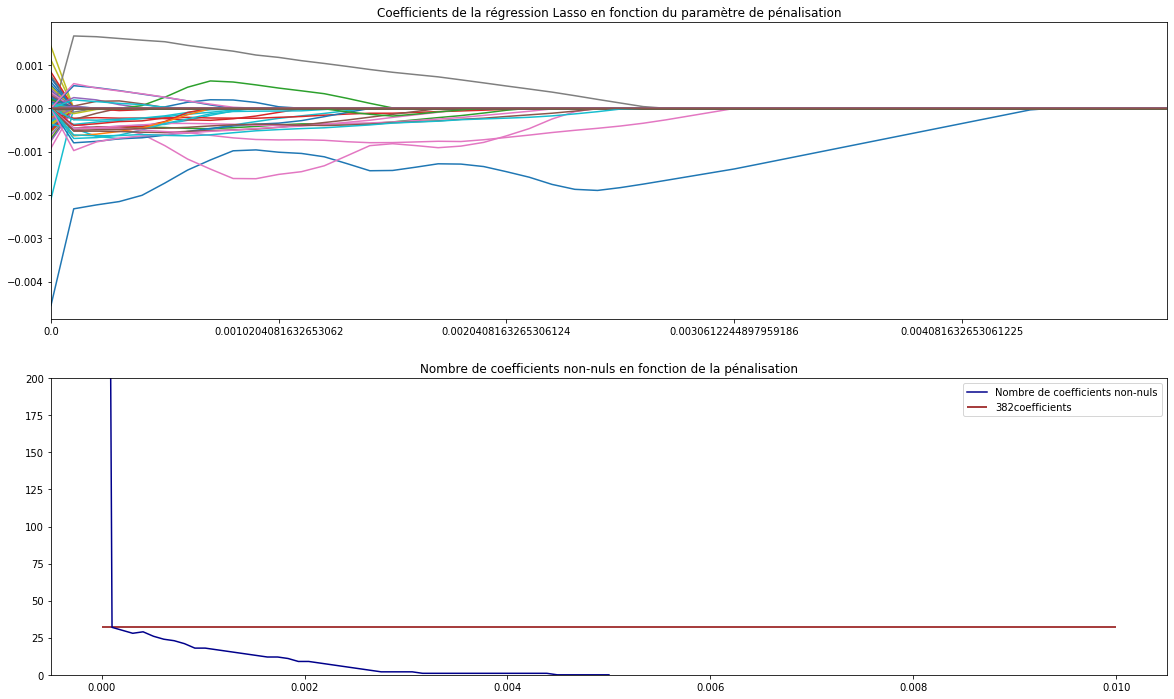

In [233]:
coefs_cleared_var = pd.DataFrame(index=yty_var_indice_cleared.columns)
alphas_cleared_var = np.linspace(0,0.005)
nbr_coef_non_nuls_cleared_var = []

for alpha in alphas_cleared_var:
    clf = Lasso(alpha=alpha)
    clf.fit(yty_var_indice_cleared, yty_var_cleared_var)
    coefs_cleared_var[str(alpha)] = clf.coef_
    nbr_coef_non_nuls_cleared_var.append(np.count_nonzero(clf.coef_))

fig_cleared_var, (ax_cleared_var,ax_nbr_coefs_cleared_var) = plt.subplots(2,1,figsize=(15,8))

coefs_cleared_var.T.plot(ax=ax_cleared_var,legend=False,title="Coefficients de la régression Lasso en fonction du paramètre de pénalisation")

ax_nbr_coefs_cleared_var.set_title("Nombre de coefficients non-nuls en fonction de la pénalisation")
ax_nbr_coefs_cleared_var.set_ylim(0,200)
ax_nbr_coefs_cleared_var.hlines(32,0,0.01,label='382coefficients',color='darkred')
ax_nbr_coefs_cleared_var.plot(alphas_cleared_var,nbr_coef_non_nuls_cleared_var,label='Nombre de coefficients non-nuls',color='darkblue')
plt.legend()

plt.show()

In [244]:
coefs_var2 = pd.DataFrame(index=yty_var_indice_cleared.columns)
alphas = [0.00010204,0.00112245,0.0022449,0.00326531]

for alpha in alphas:
    clf_var = Lasso(alpha=alpha)
    clf_var.fit(yty_var_indice_cleared, yty_var_cleared_var)
    coefs_var2[str(alpha)] = clf_var.coef_

variables_modele_tres_complexe_cleared_var = list(coefs_var2.loc[coefs_var2['0.00010204']!=0].index)
variables_modele_complexe_cleared_var = list(coefs_var2.loc[coefs_var2['0.00112245']!=0].index)
variables_modele_simple_cleared_var = list(coefs_var2.loc[coefs_var2['0.0022449']!=0].index)
variables_modele_tres_simple_cleared_var = list(coefs_var2.loc[coefs_var2['0.00326531']!=0].index)

## Corrélations sur le modèle très complexe

In [267]:
''' On concatène les variables à tester '''

tres_complexe = list(pd.DataFrame(variables_modele_tres_complexe_cleared_var + variables_modele_tres_complexe_cleared_lvl).drop_duplicates().iloc[:,0])
complexe = list(pd.DataFrame(variables_modele_complexe_cleared_var + variables_modele_complexe_cleared_lvl).drop_duplicates().iloc[:,0])
simple = list(pd.DataFrame(variables_modele_simple_cleared_var + variables_modele_simple_cleared_lvl).drop_duplicates().iloc[:,0])
tres_simple = list(pd.DataFrame(variables_modele_tres_simple_cleared_var + variables_modele_tres_simple_cleared_lvl).drop_duplicates().iloc[:,0])

total = list(pd.DataFrame(tres_complexe + complexe + simple + tres_simple).drop_duplicates().iloc[:,0])

''' On restreint la dataframe à ces variables '''

X_new = X[total]
X_trim_new = X_cleared_trimestriel[total]
X_var_new = yty_var_indice_cleared[total]


### Graphiques